In [ ]:
import numpy as np
from numpy import linalg as LA
from sklearn import cluster
from sklearn.decomposition import PCA

In [ ]:
import numpy as np
# from contrastive import CPCA

N = 400; D = 30; gap=3
# In B, all the data pts are from the same distribution, which has different variances in three subspaces.
B = np.zeros((N, D))
B[:,0:10] = np.random.normal(0,10,(N,10))
B[:,10:20] = np.random.normal(0,3,(N,10))
B[:,20:30] = np.random.normal(0,1,(N,10))


# In A there are four clusters.
A = np.zeros((N, D))
A[:,0:10] = np.random.normal(0,10,(N,10))
# group 1
A[0:100, 10:20] = np.random.normal(0,1,(100,10))
A[0:100, 20:30] = np.random.normal(0,1,(100,10))
# group 2
A[100:200, 10:20] = np.random.normal(0,1,(100,10))
A[100:200, 20:30] = np.random.normal(gap,1,(100,10))
# group 3
A[200:300, 10:20] = np.random.normal(2*gap,1,(100,10))
A[200:300, 20:30] = np.random.normal(0,1,(100,10))
# group 4
A[300:400, 10:20] = np.random.normal(2*gap,1,(100,10))
A[300:400, 20:30] = np.random.normal(gap,1,(100,10))
A_labels = [0]*100+[1]*100+[2]*100+[3]*100



In [ ]:
fg = A                        #  store the number of features and number of cells
bg = B
n_fg, features_d = A.shape
n_bg, features_d_bg = B.shape

In [ ]:
if not(features_d==features_d_bg):
  raise ValueError('The dimensionality of the foreground and background datasets must be the same')

preprocess_with_pca_dim = 1000

In [ ]:
def standardize_array(array):          # standarizing the data 
  standardized_array =  (array-np.mean(array,axis=0)) / np.std(array,axis=0)
  return np.nan_to_num(standardized_array)

In [ ]:
 #Center the background and foreground data
bg = bg - np.mean(bg, axis=0)

bg = standardize_array(bg)

fg = fg - np.mean(fg, axis=0)

fg = standardize_array(fg)

In [ ]:
if (features_d>preprocess_with_pca_dim):           ##if the dimension is higher than preprocess_with_pca_dim, then PCA is performed to reduce the dimensionality
  data = np.concatenate((fg, bg),axis=0)
  pca = PCA(n_components = preprocess_with_pca_dim)
  data = pca.fit_transform(data)
  fg = data[:n_fg,:]
  bg = data[n_fg:,:]
  features_d = preprocess_with_pca_dim


#Calculate the covariance matrices
bg_cov = bg.T.dot(bg)/(bg.shape[0]-1)
fg_cov = fg.T.dot(fg)/(n_fg-1)

In [ ]:
dataset = fg                  # stored some of parameters and assigned values to them
alpha_selection='auto'
n_alphas=40
max_log_alpha=3
n_alphas_to_return=4
plot=False
active_labels = A_labels
colors = ['k','r','b','g','c']
legend=None
alpha_value=None
return_alphas=False

In [ ]:
"""
Returns active and bg dataset projected in the cpca direction, as well as the top c_cpca eigenvalues indices.
If specified, it returns the top_cpca directions
"""
def cpca_alpha(dataset, alpha=1):
  n_components = 2
  sigma = fg_cov - alpha*bg_cov
  w, v = LA.eig(sigma)
  eig_idx = np.argpartition(w, -n_components)[-n_components:]
  eig_idx = eig_idx[np.argsort(-w[eig_idx])]
  v_top = v[:,eig_idx]
  reduced_dataset = dataset.dot(v_top)
  reduced_dataset[:,0] = reduced_dataset[:,0]*np.sign(reduced_dataset[0,0])
  reduced_dataset[:,1] = reduced_dataset[:,1]*np.sign(reduced_dataset[0,1])
  return reduced_dataset

In [ ]:
#created affinity matrix
from math import pi
alphas = np.concatenate(([0],np.logspace(-1,max_log_alpha,n_alphas)))
subspaces = list()
k = len(alphas)
affinity = 0.5*np.identity(k) #it gets doubled
for alpha in alphas:
    space = cpca_alpha(dataset=fg, alpha=alpha)
    q, r = np.linalg.qr(space)     #Compute the qr factorization of a matrix.
    subspaces.append(q)
for i in range(k):
    for j in range(i+1,k):
        q0 = subspaces[i]
        q1 = subspaces[j]
        u, s, v = np.linalg.svd(q0.T.dot(q1))
        affinity[i,j] = s[0]*s[1]
affinity = affinity + affinity.T
affinity_matrix = np.nan_to_num(affinity)

In [ ]:
q1.shape

(400, 2)

In [ ]:
# This method performs spectral clustering on the affinity matrix of subspaces
#     returned by contrastive pca, and returns (`=3) exemplar values of alpha

affinity = affinity_matrix
spectral = cluster.SpectralClustering(n_clusters=n_alphas_to_return, affinity='precomputed') #Apply clustering to a projection of the normalized Laplacian.
alphas = np.concatenate(([0],np.logspace(-1,max_log_alpha,n_alphas)))
spectral.fit(affinity)
labels = spectral.labels_
best_alphas = list()
for i in range(n_alphas_to_return):
    idx = np.where(labels==i)[0]
    if not(0 in idx): #because we don't want to include the cluster that includes alpha=0
        affinity_submatrix = affinity[idx][:, idx]
        sum_affinities = np.sum(affinity_submatrix, axis=0)
        exemplar_idx = idx[np.argmax(sum_affinities)]
        best_alphas.append(alphas[exemplar_idx])

best_alphas, all_alphas, _, _ =  np.sort(best_alphas), alphas, affinity[0,:], labels

In [ ]:
#lets do for autoselected alpha
best_alphas = np.concatenate(([0], best_alphas)) #one of the alphas is always alpha=0
data_to_plot = []
for alpha in best_alphas:
    transformed_dataset = cpca_alpha(dataset=dataset, alpha=alpha)
    data_to_plot.append(transformed_dataset)




In [ ]:
data_to_plot

[array([[ 3.48447106,  2.62999263],
        [ 2.86182358,  2.95837232],
        [ 3.47005112,  3.00638718],
        [ 3.31191634,  1.96515161],
        [ 3.50390263,  2.81217281],
        [ 3.43507235,  3.77451449],
        [ 2.64578345,  2.46493121],
        [ 3.40954333,  1.83980385],
        [ 3.5105906 ,  2.33713198],
        [ 2.72762976,  3.3941562 ],
        [ 3.12318866,  2.35398712],
        [ 3.18651638,  3.65998843],
        [ 3.37314303,  3.68363595],
        [ 2.88978159,  2.78698064],
        [ 3.08803643,  3.15896094],
        [ 2.67682763,  2.59911829],
        [ 3.40765355,  2.88602476],
        [ 2.96788671,  1.17102468],
        [ 3.1263571 ,  2.26989305],
        [ 3.2511672 ,  3.91398601],
        [ 3.04393731,  1.2333619 ],
        [ 3.30152491,  1.54572176],
        [ 2.87618694,  3.26030286],
        [ 3.16966916,  2.50067105],
        [ 2.46960894,  2.43377028],
        [ 2.88022469,  2.52202919],
        [ 3.36048664,  2.0743993 ],
        [ 3.30389537,  2.608

In [ ]:
import matplotlib.pyplot as plt

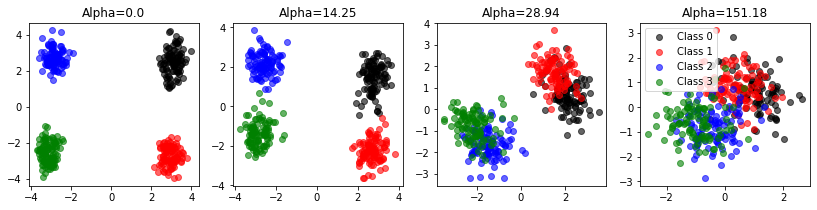

In [ ]:
transformed_data = data_to_plot
plt.figure(figsize=[14,3])
for j, fg in enumerate(transformed_data):
    plt.subplot(1,4,j+1)
    for i, l in enumerate(np.sort(np.unique(active_labels))):
        idx = np.where(active_labels==l)
        plt.scatter(fg[idx,0],fg[idx,1], color=colors[i%len(colors)], alpha=0.6, label='Class '+str(i))
    plt.title('Alpha='+str(np.round(best_alphas[j],2)))
if len(np.unique(active_labels))>1:
    plt.legend()

plt.show()
